Based On Arshia Azfal's Code:
Based Arshia Azfal's code: Training the Vision Transformer model to classify the intended upperlimb movement using continuous wavelet features. Preprocessing of the data using Etienne Montalivet's MNEFilter.

In [ ]:
!pip install -q PyWavelets torch_geometric lightning wandb mne

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import numpy as np
import glob
import os
from tqdm import tqdm
import csv
import random
import h5py
import sys
import pywt

from torch.profiler import profile, record_function, ProfilerActivity

import torch.nn.functional as F
import scipy.io as sio

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.data import Data
import lightning as L

from torch_geometric.loader import DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import wandb

import matplotlib.pyplot as plt
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from torchmetrics.classification import MulticlassF1Score

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/INL')
from transform import MNEFilter
import mne

In [ ]:
fs = 590 #Sampling frequency
n_ecogs = 31 #number of ecog channels
window_duration = 3 #seconds
num_classes = 6

In [ ]:
y = np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/label2.npy')
X_train =  np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/X_train2.npy')


y_test = np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/label_test.npy')
X_test =  np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/X_test.npy')

In [ ]:
X_train.shape

(11730, 31, 1770)

In [ ]:
#Preprocess the data before reshaping for the Transformer
sfreq=fs
l_freq=1
h_freq=200
notch_freqs=[50, 100, 150, 200]
apply_car=True

mne_filter = MNEFilter(sfreq=sfreq, l_freq=l_freq, h_freq=h_freq, notch_freqs=notch_freqs, apply_car=apply_car)

In [ ]:
"""
filtered_data_train = []
filtered_data_test = []

mne.set_log_level("error")
for window in tqdm(X_train):
  filtered_window = mne_filter(window)
  filtered_data_train.append(filtered_window)

for window in tqdm(X_test):
  filtered_window = mne_filter(window)
  filtered_data_test.append(filtered_window)

"""
#skip preprocessing
filtered_data_train = X_train
filtered_data_test = X_test

In [ ]:
print(len(filtered_data_train))
print(len(filtered_data_test))

11730
2237


In [ ]:
np.array(filtered_data_train).shape

(11730, 31, 1770)

In [ ]:
X_train = np.array(filtered_data_train).reshape(-1, n_ecogs * window_duration,fs)
X_test = np.array(filtered_data_test).reshape(-1,n_ecogs * window_duration,fs)

In [ ]:
dataset = []

for idx in tqdm(range(X_train.shape[0])):
    eeg_clip = X_train[idx,:,:]
    label = y[idx]
    if label == 7 or label == 4: #ignore label 7, which produces weird results
        continue
    if label >= 5:
      label = label - 1 #Remap to remove wrist supination
    dataset.append((torch.tensor(eeg_clip).float(), torch.tensor((label), dtype=torch.long)))

random.shuffle(dataset)


dataset_test = []

for idx in tqdm(range(X_test.shape[0])):
    eeg_clip = X_test[idx,:,:]
    label = y_test[idx]
    if label == 7 or label == 4: #ignore label 7
        continue
    if label >= 5:
      label = label - 1 #Remap to remove wrist supination
    dataset_test.append( ( torch.tensor(eeg_clip).float(), torch.tensor((label) , dtype=torch.long) ) )

random.shuffle(dataset_test)

100%|██████████| 2237/2237 [00:00<00:00, 2617.54it/s]


In [ ]:
train_dataloader = DataLoader(dataset , batch_size = 8, num_workers = 7)
test_dataloader = DataLoader(dataset_test , batch_size = 8)

In [ ]:
device = "cpu"#"cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()


        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x



class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_t_pints,
        num_heads,
        num_layers,
        num_classes,
        num_patches,
        num_scales,
        dropout=0.0,
        wavelet='morl',
        device = 'cpu'
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            patch_size: Number of pixels that the patches have per dimension
            num_patches: Maximum number of patches an image can have
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.device = device

        self.input_layer = nn.Linear(num_t_pints  , embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + (num_patches * num_scales), embed_dim))
        self.scales = np.arange(1, num_scales + 1)
        self.num_patches = num_patches
        self.num_scales = num_scales
        self.num_t_pints = num_t_pints
        self.wavelet = wavelet

    def forward(self, x):
        # Preprocess input
        #x = torch.stack([torch.from_numpy(self.mne_filter(sample.cpu().numpy())) for sample in x])
        #x = x.cuda().float()

        #x = torch.log( torch.abs( torch.fft.fft(x , dim=-1) ) + 1e-10 )
        #print(f"Before wavelet transform: {x.shape}")
        wavelet_features = []
        for batch in x:
            batch_features = []
            for channel in batch:
                coefs, _ = pywt.cwt(channel.cpu().numpy(), self.scales, self.wavelet)

                batch_features.append(torch.tensor(coefs, dtype=torch.float32).to(self.device))  # (n_scales, n_samples)
            wavelet_features.append(torch.stack(batch_features))  # (n_channels, n_scales, n_samples)

        wavelet_features = torch.stack(wavelet_features) # (batch_size, n_channels, n_scales, n_samples)
        x = wavelet_features
        x = x.view(-1, self.num_patches * self.num_scales, self.num_t_pints)

        #print(f"After wavelet transform: {x.shape}")


        #x = torch.cat( [torch.log(torch.abs( torch.fft.fft(x , dim=-1).imag[:,:,0:295]))  , torch.log(torch.abs(torch.fft.fft(x , dim=-1).real[:,:,0:295]) ) ] , dim=-1)

        x = (x - x.mean(dim=-1 , keepdim=True) )/x.std(dim=-1 , keepdim=True)

        B, T, _ = x.shape # B Batch, T Timepoints
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out




class ViT(L.LightningModule):
    def __init__(self, model_kwargs):
        super().__init__()

        self.model = VisionTransformer(**model_kwargs)


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):

        optimizer = optim.Adam(params=self.parameters(), lr = 1e-3)

        scheduler = CosineAnnealingLR(optimizer, T_max = 50)

        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]


    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #wandb.log({ "Bridge-GPT-Loss": loss})

        return loss

In [ ]:
"""
model_kwargs={
        "embed_dim": 64,
        "hidden_dim": 64,
        "num_heads": 8,
        "num_layers": 4,
        "num_t_pints": 590,
        "num_patches": 93,
        "num_classes": 7,
        "num_scales": 128,
        "dropout": 0.2,
    }
"""

model_kwargs={
        "embed_dim": 16,
        "hidden_dim": 32,
        "num_heads": 4,
        "num_layers": 4,
        "num_t_pints": 590,
        "num_patches": 93,
        "num_classes": num_classes,
        "num_scales": 8,
        "dropout": 0.2,
        "wavelet": "morl"
        "device": device
    }

model = ViT(model_kwargs)

In [ ]:
trainer = L.Trainer(max_epochs= 20, accelerator="cpu") #trainer = L.Trainer(max_epochs= 50 , devices= 1, accelerator="cpu")

trainer.fit(model, train_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | VisionTransformer | 30.4 K | train
----------------------------------------------------
30.4 K    Trainable params
0         Non-trainable params
30.4 K    Total params
0.122     Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | VisionTransformer | 30.4 K | train
----------------------------------------------------
30.4 K    Trainable params
0         Non-trainable params
30.4 K    Total params
0.122     Total estimated model

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


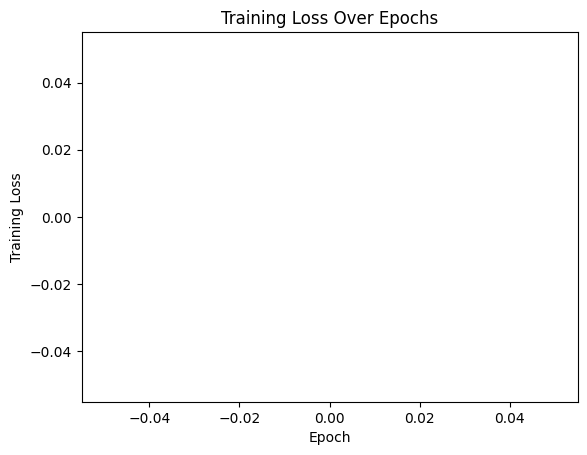

In [ ]:
import matplotlib.pyplot as plt

# Extract training loss history from `trainer` logs
train_losses = trainer.callback_metrics.get('train_loss_epoch', [])

# Plot the loss
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.show()

In [ ]:
import pytorch_lightning

torch.seed()
np.random.seed(120)
random.seed(123)
pytorch_lightning.utilities.seed

model.to(device)
l = [] #labels
gt = [] #ground thruth

for data in (tqdm(test_dataloader)):

    out = model(data[0].to(device))

    l.extend(out.to('cpu').detach().numpy())

    gt.extend(( data[1].type(torch.float32).reshape(-1,1).to('cpu') ).detach().numpy())


100%|██████████| 278/278 [02:57<00:00,  1.57it/s]


In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix

target = torch.tensor( np.array(gt).reshape(-1,) )
label =   torch.squeeze( torch.tensor( np.array(l)) )

metric = MulticlassConfusionMatrix(num_classes=num_classes)

c = np.array(metric(torch.argmax(label,-1) , target))

In [ ]:
label_dict = {0: 'state__idle',
           1: 'state__shoulder__flexion',
           2: 'state__elbow__extension',
           3: 'state__wrist__pronation',
           4: 'state__hand__open',
           5: 'state__hand__close',
          }

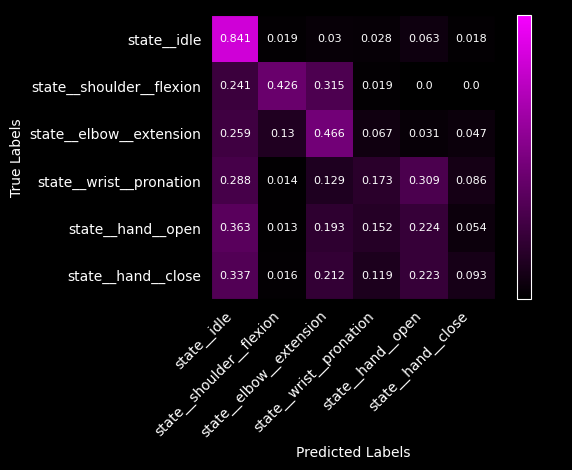

In [ ]:
# import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

C = c

colors = ['k' , '#F601FF'] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=200)

class_labels = [0, 1, 2, 3, 4, 5]

normalized_confusion_matrix =  np.round(C/ np.sum(C, axis=1, keepdims=True), 3)

fig, ax = plt.subplots(facecolor='k')
im = ax.imshow(normalized_confusion_matrix , cmap = cm , vmin=0, vmax=1)
cb = fig.colorbar(im , ax=ax)
cb.outline.set_edgecolor('w')

ax.set_xlabel("Predicted Labels", color='w')
ax.set_ylabel("True Labels", color='w')

ax.set_xticks(np.arange(len(class_labels)), labels=[name for _, name in  label_dict.items()], color='w', rotation=45, ha='right')
ax.set_yticks(np.arange(len(class_labels)), labels=[name for _, name in  label_dict.items()], color='w')




for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, normalized_confusion_matrix[i, j],
                        ha="center", va="center", color="w" , size=8)


fig.tight_layout()
plt.show()

In [ ]:
diagonal_avg = np.mean(np.diag(normalized_confusion_matrix))
print("Diagonal Average of Confusion Matrix:", diagonal_avg)

# Initialize the F1 metric (macro-average)
f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro')

# Compute the F1 score
f1_score = f1_metric(torch.argmax(label,-1) , target)
print("Macro-Averaged F1-Score:", f1_score.item())

Diagonal Average of Confusion Matrix: 0.3705
Macro-Averaged F1-Score: 0.35051241517066956
